# Constructing Fisher intervals when the KS statistic is the test statistic used in a permutation test

This file was tested on Matlab version 2019b, using the Jupyter `matlab_kernel`.

###  Matlab preliminaries

In [1]:
rng('default'); % set seed for replicability
addpath('../m'); % assumes we are in the /demo/ folder as pwd.

##  The basic problem

How do we test a non-zero, sharp null hypothesis of an additive treatment effect $\tau_0$, using a KS test?  

Recall that when the hypothesized $\tau_0=0$, then the standard randomization inference gives a permutation distribution for the KS statistic, and we conduct a _right tailed_ test that compares the actual estimate, $\widehat{KS}$, to this distribution.

On the other hand, when the null hypothesis in question is a non-zero (additive, say) treatment effect, $\tau_0\neq 0$, things are not quite so simple.  Following the usual Fisher logic, it is possible to construct a randomization distribution of the KS statistic under that null; call this $F(KS;\tau_0)$.  But notice two complications.

First, it is possible for the actual estimate $\widehat{KS}$ to be 'unsusual' relative to the distribution $F(\cdot)$ _either_ because it is too small, or because it is too large.  This seems incongruent for a test statistic that is intended for a one-sided test, and seems that it may lead to strange behavior when we switch from nulls of $\tau_0=0$, in which case we use a one-sided test, to nulls of $\tau_0 \neq 0$, in which case we would use a two-sided test.

Second and more fundamentally, the fact that the KS statistic is based on the **absolute value** of the (vertical) difference between CDFs means that $p$-values do not decrease monotonically as the hypothesized value gets farther from the truth.  This behavior is particularly problematic for the (common, useful) cases in which the CI spans zero (i.e., we have failed to reject the null of equality in distributions).  This is related to the inherent symmetry of the KS statistic.  

We can show this below by creating data for $N=500$ observations, with $y_0 \sim N(0,1)$, $y_1 = y_0 + \tau$, and $\tau=1$. Treatment, $T$, is assigned at random with probability 0.5.  


In [2]:
N=500;
y0 = randn(N,1);
tau = 1; 
y1 = y0 + tau;
T = (rand(N,1)>0.5);
y = y0 + T.*(y1-y0);

Now consider a range of candidate null hypotheses $\tau_0 \in [-1,3]$. 

In [3]:
TAU0 = [-2:0.1:2];

For each of these we can generate a randomization distribution for the KS statistic $F(KS;\tau_0)$, and we can collect either a one- or a two-sided $p$-value.  

In [4]:
P_2tailed = NaN(size(TAU0));
P_1tailed = NaN(size(TAU0));

For speed we will use $R=100$ alternative assignments to generate this distribution. Let the $N\times R$ matrix $T_0$ hold these alternative assignments.

In [5]:
R=100;
T0 = (rand(N,R)>0.5);

Loop over the hypothesized values of $\tau$, and conduct RI for each.

In [6]:
[~,~,ks] = kstest2(y(T==1),y(T==0)); % this is the actual value of the KS statistic in the data.

KS0 = NaN(R,length(TAU0)); % container for distributions of KS stats under each null

In [7]:
% RI distributions
for tt = 1:length(TAU0)
    tau0 = TAU0(tt);
    y0star = y - tau0*T;  % this would be y0 if the null were correct.
    for rr = 1:R
        ystar = y0star + tau0*T0(:,rr);  % this would be y if null were correct and assignement were T(:,rr) 
        [~,~,KS0(rr,tt)] = kstest2(ystar(T0(:,rr)==1),ystar(T0(:,rr)==0));
    end
end

In [8]:
%  P-values
P_1tailed = mean(KS0 > ks); 
P_2tailed = 2*min(mean(KS0>ks),mean(KS0<ks));

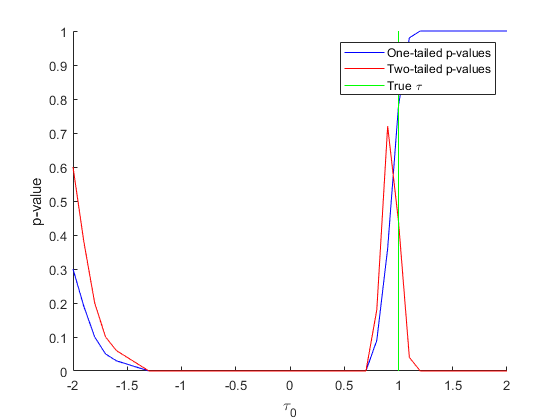

In [9]:
%  Plotting
figure(1)
clf 
hax = axes;
hold on
p1 =line(TAU0,P_1tailed, 'color','blue');
p2 =line(TAU0,P_2tailed,'color','red');
p3 =line([tau tau],get(hax,'YLim'),'color','green');
legend([p1 p2 p3],{'One-tailed p-values','Two-tailed p-values','True \tau'})
xlabel('\tau_0')
ylabel('p-value')
hold off

Notice a few things about the above results:

- For both test statistics, $p$-values are non-monotonic in distance from the true coefficient, when we cross a treatment effect of zero.
- Clearly, the one-tailed p-values cannot be the basis for establishing a CI, since they are monotonically increasing in the hypothesized treatment effect, $\tau_0$, even locally around the true coefficient of $\tau=1$.
- The two-tailed $p$-values are also asymmetric, even locally, around the truth.

All in all, this looks deeply problematic for using the standard algorithm to construct confidence intervals when RI is conducted using the KS statistic.

##  A proposed solution

Consider the following, alternative algorithm for testing the sharp null $\tau_0$.

1.  Construct $y_0^*(\tau_0) = y - \tau_0 T$, the potential outcome in the absence of treatment under this null.  
2.  Compute a KS statistic comparing the distributions of $y_0^*(\tau_0)$ for those who were in fact assigned to treatment to those who were in fact assigned to control: $y_0^*(\tau_0;T=1)$ vs $y_0^*(\tau_0;T=0)$. Call this $KS_0(\tau_0; T)$.
3.  For each of $R$ alternative permutations of the treatment, $T_r$, compute a KS statistic using the same computed values of $y_0^*$ (i.e., without adding back on the hypothesized treatment effect):  $y_0^*(\tau_0,T_r=1)$ vs $y_0^*(\tau_0;T_r=0)$. Call this $KS_0(\tau_0,T_r)$.
4.  The $p$-value for $\tau_0$ is given by the share of draws, $r$,such that $KS_0(\tau_0,T_r) > KS_0(\tau_0,T)$. 

Some helpful features of this approach:

- Because it is based on the distribution of the untreated potential outcome, $y_0$, if the null $\tau_0$ is true, the two CDFs should lie on top of one another under the null. So, the usual two-sided KS statistic is appropriate to judge deviations from this.
- When the null in question is the zero null $\tau_0=0$, then this is identical to the procedure used in RI to test the null that the distributions are the same. So, if this test fails to reject, the CI will have to contain zero. In this sense, the CI should be consistent with the $p$-value for the sharp null that $\tau_0=0$.

The key question is whether coverage is appropriate when the truth non-zero.  If we impose $\tau_0=\tau$, with $\tau$ the true, additive treatment effect, will the test have exact coverage?

In [14]:
%  Parameters
N = 500; % number of observations
S = 1000 ; % number of simulations
R = 2000 ; % number of permutations of the treatment used in RI, within each simulation.

tau = 1 ; % true treatment effect
tau0 = 1 ; % hypothesized treatment effect.

In [22]:
KS1 = NaN(1,S); % container for actual estimates
KS0 = NaN(R,S); % container distributions under the null

for ss = 1:S 
    %  DGP 
    y0 = randn(N,1);
    T = rand(N,1) > 0.5; 
    y = y0 + tau * T ;
    
    %  Alternative assignments of the treatment 
    T0 = rand(N,R) > 0.5;
    
    y0star = y - tau0*T ; % y0 under the null. In this case, it's exact.
    [~,~,KS1(ss)] = kstest2(y0star(T==1),y0star(T==0)); % test statistic for actual assignment.
    for rr = 1:R
        [~,~,KS0(rr,ss)] = kstest2(y0star(T0(:,rr)==1),y0star(T0(:,rr)==0));    
    end
end

In [24]:
%  Calculating rejection rates
Pvalues = mean(KS0 >= repmat(KS1,[R,1]));
sprintf('The share rejected at the 5 pct level is %0.3f',mean(Pvalues < 0.05))


ans =

    'The share rejected at the 5 pct level is 0.057'




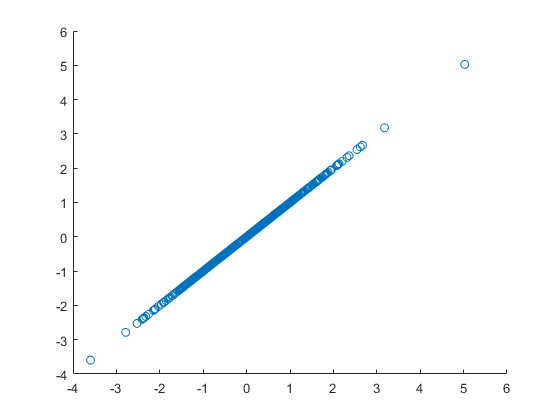

In [26]:
%  Strange that the above over-rejects, ever so slightly.  
%  Confirming that we are recovering the true counterfactual distribution, y0.  
%  If so there is no reason for KS(T) to be unusual among KS(T0).
scatter(y0,y0star)